In [1]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.0 MB/s 
     |████████████████████████████████| 4.2 MB 18.6 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 
     |████████████████████████████████| 6.6 MB 38.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=6b3dce364ba0f164077650bcb5a3cacfee2587d9e2eea570871c31d4440d2b01
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import re
import os
import spacy
#import distance
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from prettytable import PrettyTable
from scipy.spatial.distance import cosine
from scipy.sparse import save_npz, load_npz, hstack
from sentence_transformers import SentenceTransformer

import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

%matplotlib inline

In [3]:
from sklearn.model_selection import ShuffleSplit

In [5]:
train = pd.read_csv("/content/data/df_fe_without_preprocessing_train.csv")
train.head()

,Unnamed: 0,Question,Marking Scheme,Student Response,Answer Rating,ms_le,st_le,ms_n_words,st_n_words,word_Common,word_Total,word_share
0,0,What is meant by fixed cost?,cost change output production short run,fixed cost refers cost things change output eq...,3,39,163,6,24,5.0,26.0,0.192308
1,1,What is meant by fixed cost?,cost change output production short run,cost things change output,2,39,25,6,4,3.0,10.0,0.300000
2,2,What is meant by fixed cost?,cost change output production short run,fixed cost cost things fixed,1,39,28,6,5,1.0,9.0,0.111111
3,3,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price refers price market quantity...,3,159,253,20,33,7.0,31.0,0.225806
4,4,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price price market equilibrium sho...,1,159,113,20,13,4.0,18.0,0.222222


In [6]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [7]:
# It took a lot of time, caused gpu overheat.
# So I decided to do it in batch and save them in file.
def getBertEmbeddings(data, filename):
    batch = 20000
    with open(filename, 'wb') as f:
        while(len(data)):
            tempdata = data[:batch]
            data = data[batch:]
            tempembed = model.encode(tempdata.values, device='cpu', normalize_embeddings = True)
            np.save(f, tempembed, allow_pickle=True)
#             time.sleep(60) # for gpu heating issue
            

In [8]:
# Get SentenceBERT embedding of train data
getBertEmbeddings(train["Marking Scheme"], 'temp_ms_sentenceBERT.npy')
getBertEmbeddings(train["Student Response"], 'temp_sr_sentenceBERT.npy')

In [9]:
# Get cosine similarity and euclidean distance between two vectors
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])

In [10]:
# open .npy files and loop through the sentence embeddings
with open('temp_ms_sentenceBERT.npy', 'rb') as ms_vec, open('temp_sr_sentenceBERT.npy', 'rb') as sr_vec:
    distances = []
    while True:
        try:
            ms_20k = np.load(ms_vec, allow_pickle=True)
            sr_20k = np.load(sr_vec, allow_pickle=True)
            for ms,sr in zip(ms_20k, sr_20k):
                dists = cosine_euclidean(ms, sr)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break

In [11]:
sr_vectors = pd.DataFrame(sr_20k)

In [12]:
ms_vectors = pd.DataFrame(ms_20k)

In [13]:
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])

In [14]:
train = pd.concat([train, pd.DataFrame(distances)], axis=1)


In [15]:
train = pd.concat([train, pd.DataFrame(sr_vectors)], axis=1)
train = pd.concat([train, pd.DataFrame(ms_vectors)], axis=1)


In [16]:
train.head()

,Unnamed: 0,Question,Marking Scheme,Student Response,Answer Rating,ms_le,st_le,ms_n_words,st_n_words,word_Common,...,758,759,760,761,762,763,764,765,766,767
0,0,What is meant by fixed cost?,cost change output production short run,fixed cost refers cost things change output eq...,3,39,163,6,24,5.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
1,1,What is meant by fixed cost?,cost change output production short run,cost things change output,2,39,25,6,4,3.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
2,2,What is meant by fixed cost?,cost change output production short run,fixed cost cost things fixed,1,39,28,6,5,1.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
3,3,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price refers price market quantity...,3,159,253,20,33,7.0,...,0.010258,0.038903,-0.035040,0.026163,0.021026,-0.068717,-0.014177,-0.018438,0.000991,-0.023500
4,4,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price price market equilibrium sho...,1,159,113,20,13,4.0,...,0.010258,0.038903,-0.035040,0.026163,0.021026,-0.068717,-0.014177,-0.018438,0.000991,-0.023500


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 1550 entries, Unnamed: 0 to 767
dtypes: float32(1538), float64(3), int64(6), object(3)
memory usage: 1.7+ MB


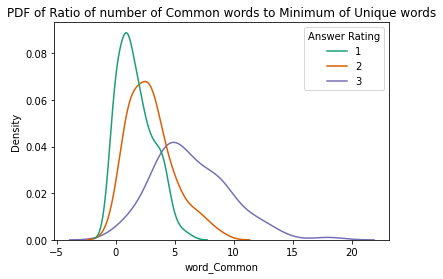

In [83]:
plt.title('PDF of Ratio of number of Common words to Minimum of Unique words')
sns.kdeplot(train['word_Common'], hue=train["Answer Rating"], palette="Dark2")
plt.show()

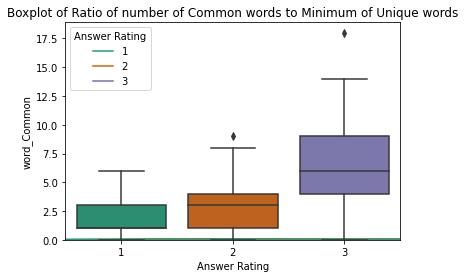

In [82]:

plt.title('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=train["Answer Rating"], y=train['word_Common'], palette="Dark2")
plt.show()

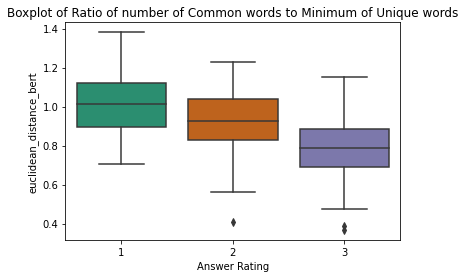

In [80]:

plt.title('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=train["Answer Rating"], y=train['euclidean_distance_bert'], palette="Dark2")
plt.show()

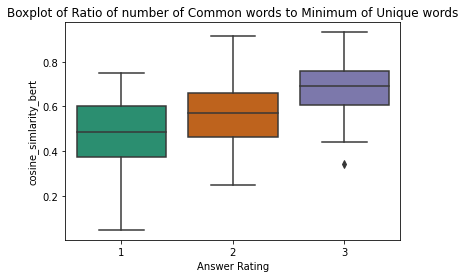

In [84]:
plt.title('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=train["Answer Rating"], y=train['cosine_simlarity_bert'], palette="Dark2")
plt.show()

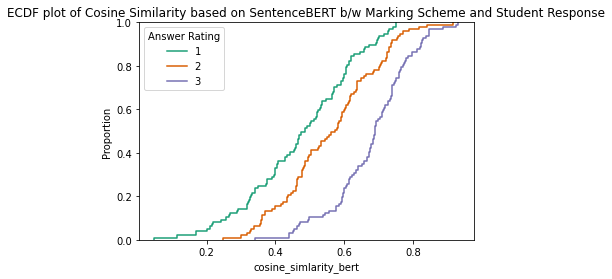

In [21]:
plt.title('ECDF plot of Cosine Similarity based on SentenceBERT b/w Marking Scheme and Student Response')
sns.axes_style("whitegrid")
sns.ecdfplot(x=train['cosine_simlarity_bert'], hue=train["Answer Rating"], palette="Dark2")
plt.show()

In [22]:
train

,Unnamed: 0,Question,Marking Scheme,Student Response,Answer Rating,ms_le,st_le,ms_n_words,st_n_words,word_Common,...,758,759,760,761,762,763,764,765,766,767
0,0,What is meant by fixed cost?,cost change output production short run,fixed cost refers cost things change output eq...,3,39,163,6,24,5.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
1,1,What is meant by fixed cost?,cost change output production short run,cost things change output,2,39,25,6,4,3.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
2,2,What is meant by fixed cost?,cost change output production short run,fixed cost cost things fixed,1,39,28,6,5,1.0,...,0.025210,0.009434,-0.006061,0.000311,0.000562,-0.086548,-0.005957,0.007805,-0.042130,-0.021521
3,3,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price refers price market quantity...,3,159,253,20,33,7.0,...,0.010258,0.038903,-0.035040,0.026163,0.021026,-0.068717,-0.014177,-0.018438,0.000991,-0.023500
4,4,What is the difference between equilibrium pri...,equilibrium price demand supply equal surpluse...,equilibrium price price market equilibrium sho...,1,159,113,20,13,4.0,...,0.010258,0.038903,-0.035040,0.026163,0.021026,-0.068717,-0.014177,-0.018438,0.000991,-0.023500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,286,Analyse the advantages of selling a product wh...,price inelastic demand means price increases q...,competition exist firm always improve revenue ...,2,427,62,57,8,2.0,...,0.027825,0.048647,0.069437,-0.003526,0.019164,-0.104717,0.010744,0.013316,0.011663,-0.002209
287,287,Analyse the advantages of selling a product wh...,price inelastic demand means price increases q...,price inelastic demand means demand changes sm...,3,427,233,57,32,9.0,...,0.027825,0.048647,0.069437,-0.003526,0.019164,-0.104717,0.010744,0.013316,0.011663,-0.002209
288,288,Analyse how a rise in the interest rate could ...,higher interest rate would increase cost borro...,higher interest rate generally reduce total de...,2,589,83,82,11,7.0,...,0.010386,0.007827,0.034519,0.030958,0.001107,-0.088145,0.014553,-0.017289,-0.006984,0.024977
289,289,Analyse how a rise in the interest rate could ...,higher interest rate would increase cost borro...,higher interest rate bad economy makes everyth...,1,589,56,82,9,3.0,...,0.010386,0.007827,0.034519,0.030958,0.001107,-0.088145,0.014553,-0.017289,-0.006984,0.024977


In [51]:
X = train.drop(["Unnamed: 0", "Question", "Marking Scheme", "Student Response", "Answer Rating"], axis = 1)
y = train["Answer Rating"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(218, 1545)
(73, 1545)
(218,)
(73,)


In [54]:
rf = RandomForestClassifier(random_state = 24)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [55]:
print(confusion_matrix(y_pred, y_test))

[[ 9 10  3]
 [17  5  8]
 [ 0  2 19]]


In [56]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.35      0.41      0.38        22
           2       0.29      0.17      0.21        30
           3       0.63      0.90      0.75        21

    accuracy                           0.45        73
   macro avg       0.42      0.49      0.44        73
weighted avg       0.41      0.45      0.41        73



**RANDOM FOREST**

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2,5]
min_samples_leaf = [1,2]
bootstrap = [True, False]


In [60]:
"""Make a dictionary of the various parameters involving the grids that we want to search
   The grids are in a dictionary format"""

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
            }

print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [61]:
# GridSearchCV is that it is a meta-estimator
# verbose just means the text output describing the process

grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 3)

In [62]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=24), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=3)

In [63]:
grid_rf.best_params_

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 41}

In [64]:
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=2, n_estimators=41,
                       random_state=24)

In [65]:
grid_prediction = grid_rf.predict((X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [66]:
grid_prediction

array([2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 2, 3, 2, 2, 2, 1, 2, 3, 2,
       3, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3,
       2, 2, 3, 1, 3, 3, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 1,
       2, 3, 2, 2, 1, 1, 3])

In [69]:
cf_matrix = confusion_matrix(grid_prediction, y_test)
cf_matrix

array([[ 7,  2,  2],
       [19, 13,  6],
       [ 0,  2, 22]])

In [67]:
print(classification_report(grid_prediction, y_test))

              precision    recall  f1-score   support

           1       0.27      0.64      0.38        11
           2       0.76      0.34      0.47        38
           3       0.73      0.92      0.81        24

    accuracy                           0.58        73
   macro avg       0.59      0.63      0.56        73
weighted avg       0.68      0.58      0.57        73



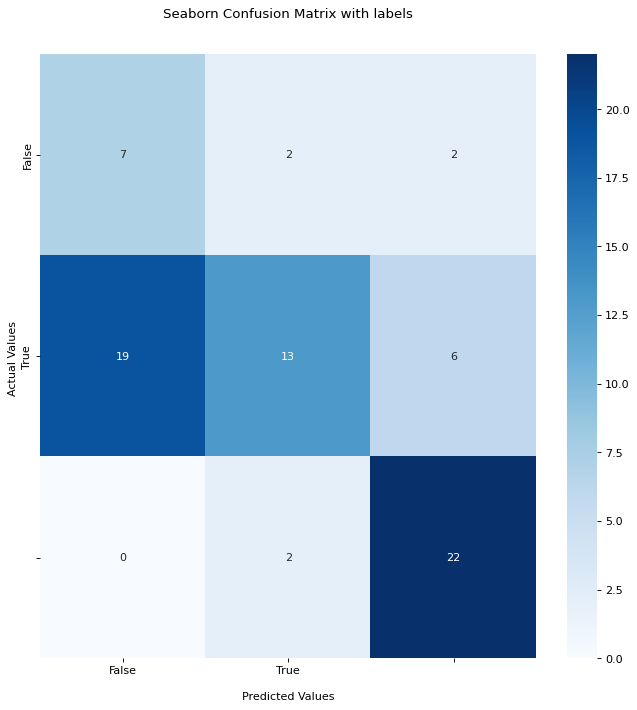

In [75]:
plt.figure(figsize=(10, 10), dpi=80)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [88]:
y_test[:5]

126    1
234    1
55     3
0      3
213    3
Name: Answer Rating, dtype: int64

In [85]:
import pickle
import joblib
file = open('model.pkl', 'wb') #save model in the pickle file
pickle.dump(rf,file)

In [87]:
with open('model.pkl', 'rb') as file: #load model as pickle file
    pickle_model = pickle.load(file)

In [90]:
result = pickle_model.predict(X_test[:5])
result

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


array([1, 2, 2, 3, 3])